In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.animation as animation
from IPython.display import HTML
from dtw import dtw
import numpy as np
from data_copying_tests import C_T
from sklearn.cluster import KMeans
from scipy.signal import savgol_filter

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
os.chdir(os.path.expanduser('~/git/mf-copula/'))

In [3]:
def load_synthetic(synthetic_csv, index_col=None):
    data = []

    for csv in os.listdir(synthetic_csv):
        if csv != 'original.csv':
            data.append(pd.read_csv(os.path.join(synthetic_csv, csv), index_col=index_col))

    X = [df[['x', 'y']].loc[df.x.notna() & df.y.notna()].astype(int) for df in data]
    
    return X

def plot_synthetic(synthetic_csv, ax, original=False):
    X = load_synthetic(synthetic_csv)

    for df in X:
        ax.scatter(df.x, df.y, alpha=.1, c='C2')
        ax.scatter(df.x.iloc[-1], df.y.iloc[-1], c='C3', marker='D', s=10, alpha=0.5)

    if original:
        orig = pd.read_csv(os.path.join(synthetic_csv, 'original.csv'))
        ax.scatter(orig.x, orig.y, alpha=1, c='C3')

    ax.scatter(orig.x.iloc[-1], orig.y.iloc[-1], c='C0', marker='D', s=75, alpha=1)
    ax.scatter(orig.x.iloc[0], orig.y.iloc[0], c='C0', marker='*', s=100, alpha=1)

    return X

In [4]:
def plot_scenario(scenario_csv, ax, original=False, scen_id=None, max_paths=None):
    X0 = load_synthetic(os.path.join(scenario_csv, 'agent0'))
    X1 = load_synthetic(os.path.join(scenario_csv, 'agent1'))
    X2 = load_synthetic(os.path.join(scenario_csv, 'agent2'))
    X3 = load_synthetic(os.path.join(scenario_csv, 'agent3'))

    if max_paths is not None:
        X0 = X0[-max_paths:]
        X1 = X1[-max_paths:]
        X2 = X2[-max_paths:]
        X3 = X3[-max_paths:]

    for X in [X0, X1, X2, X3]:
        for df in X:
            # ax.plot(df.x, df.y, alpha=.1, c='C2')
            n = max(1, len(df) // 10)
            for i in range(0, len(df)-n, n):
                ax.annotate(
                    '',
                    xy=(df.x.iloc[i+n], df.y.iloc[i+n]),
                    xytext=(df.x.iloc[i], df.y.iloc[i]),
                    arrowprops=dict(arrowstyle="->", color='C2', lw=1.5, alpha=0.75)
                )
            ax.scatter(df.x.iloc[-1], df.y.iloc[-1], c='C7', marker='D', s=10, alpha=0.5)

    if original:
        for i in range(4):
            orig = pd.read_csv(os.path.join(scenario_csv, f'agent{i}', 'original.csv'))
            n = max(1, len(orig) // 10)
            if i > 0:
                ax.plot(orig.x, orig.y, alpha=0, c='C3', linewidth=1.5)
                for j in range(0, len(orig)-n, n):
                    ax.annotate(
                        '',
                        xy=(orig.x.iloc[j+n], orig.y.iloc[j+n]),
                        xytext=(orig.x.iloc[j], orig.y.iloc[j]),
                        arrowprops=dict(arrowstyle="->", color='C3', lw=2.5)
                    )
            else:
                ax.plot(orig.x, orig.y, alpha=0, c='C0', linewidth=2.5)
                for j in range(0, len(orig)-n, n):
                    ax.annotate(
                        '',
                        xy=(orig.x.iloc[j+n], orig.y.iloc[j+n]),
                        xytext=(orig.x.iloc[j], orig.y.iloc[j]),
                        arrowprops=dict(arrowstyle="->", color='C0', lw=5)
                    )

            ax.scatter(orig.x.iloc[-1], orig.y.iloc[-1], c='black', marker='D', s=40, alpha=1)
            ax.scatter(orig.x.iloc[0], orig.y.iloc[0], c='black', marker='*', s=50, alpha=1)


    return [X0, X1, X2, X3]


In [5]:
def mean_path(df):

    x_mean = pd.concat(df, axis=1)[['x']].mean(axis=1)
    y_mean = pd.concat(df, axis=1)[['y']].mean(axis=1)

    return pd.DataFrame({'x': x_mean, 'y': y_mean})

def dtw_variation(X):
    dtw_dist = []
    mean_path_X = mean_path(X)

    for df in X:
        dtw_dist.append(dtw(mean_path_X, df).distance)

    return np.mean(dtw_dist)

In [6]:
def C_T_reshaped(Pn, Qm, T, tau=0, dim=10, n_clusters=5):
    T_reshaped = T.to_numpy()[:(-(T.shape[0] % dim) if T.shape[0] % dim > 0 else T.shape[0])].reshape(-1, dim)
    Pn_reshaped = Pn.to_numpy()[:(-(Pn.shape[0] % dim) if Pn.shape[0] % dim > 0 else Pn.shape[0])].reshape(-1, dim)
    Qm_reshaped = Qm.to_numpy()[:(-(Qm.shape[0] % dim )if Qm.shape[0] % dim > 0 else Qm.shape[0])].reshape(-1, dim)

    if np.any(np.array([T_reshaped.shape[0], Pn_reshaped.shape[0], Qm_reshaped.shape[0]]) == 0):
        print([T.shape, Pn.shape, Qm.shape])
        print([T_reshaped.shape, Pn_reshaped.shape, Qm_reshaped.shape])
        exit()

    KM = KMeans(n_clusters).fit(T_reshaped)

    T_labels = KM.predict(T_reshaped)
    Pn_labels = KM.predict(Pn_reshaped)
    Qm_labels = KM.predict(Qm_reshaped)

    return C_T(Pn_reshaped, Pn_labels, Qm_reshaped, Qm_labels, T_reshaped, T_labels, tau)


def C_T_agg(Pn, Qm_agg, T, tau=0, dim=1, n_clusters=5):
    C_Ts = []

    if dim == 1:
        KM = KMeans(n_clusters).fit(T)

        T_labels = KM.predict(T)
        Pn_labels = KM.predict(Pn)
        
        for Qm in Qm_agg:
            Qm_labels = KM.predict(Qm)
            C_Ts.append(C_T(Pn, Pn_labels, Qm, Qm_labels, T, T_labels, tau))
    else:
        for Qm in Qm_agg:
            C_Ts.append(C_T_reshaped(Pn, Qm, T, tau, dim, n_clusters))

    return np.mean(C_Ts), np.var(C_Ts)

In [7]:
def read_json(path):
    df = pd.read_json(path)

    series = [pd.DataFrame(df[col].dropna().to_list(), columns=['x','y']) for col in df.columns]
        
    return series

In [8]:
pprint = lambda x: f'{x[0]:7.2f}\t{x[1]:7.2f}\t{np.sqrt(x[1])/x[0]:7.2f}'

In [9]:
star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
cut_star = mpath.Path(
    vertices=np.concatenate([circle.vertices, star.vertices[::-1, ...]]),
    codes=np.concatenate([circle.codes, star.codes]))

def animate_scenario(path0, path1, path2, path3, orig0=None, orig1=None, orig2=None, orig3=None, savefile=None):
    fig, ax = plt.subplots()

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    min_frames = min(path0.shape[0], path1.shape[0], path2.shape[0], path3.shape[0])
    if orig0 is not None:
        min_frames = min(min_frames, orig0.shape[0], orig1.shape[0], orig2.shape[0], orig3.shape[0])

    line0, = ax.plot([], [], c='C0')
    line1, = ax.plot([], [], c='C3')
    line2, = ax.plot([], [], c='C3')
    line3, = ax.plot([], [], c='C3')

    orig_line0, = ax.plot([], [], c='C9')
    orig_line1, = ax.plot([], [], c='C5')
    orig_line2, = ax.plot([], [], c='C5')
    orig_line3, = ax.plot([], [], c='C5')

    mark0 = ax.scatter([], [], marker=star, color='C0', label='Runner')
    mark1 = ax.scatter([], [], marker=cut_star, color='C3', label='Chaser 1')
    mark2 = ax.scatter([], [], marker=cut_star, color='C3', label='Chaser 2')
    mark3 = ax.scatter([], [], marker=cut_star, color='C3', label='Chaser 3')

    orig_mark0 = ax.scatter([], [], marker=star, color='C9')
    orig_mark1 = ax.scatter([], [], marker=cut_star, color='C5')
    orig_mark2 = ax.scatter([], [], marker=cut_star, color='C5')
    orig_mark3 = ax.scatter([], [], marker=cut_star, color='C5')

    def init():
        if orig0 is not None:
            ax.set_xlim(min(min(orig0.x), min(orig1.x), min(orig2.x), min(orig3.x)),
                        max(max(orig0.x), max(orig1.x), max(orig2.x), max(orig3.x)))
            ax.set_ylim(min(min(orig0.y), min(orig1.y), min(orig2.y), min(orig3.y)),
                        max(max(orig0.y), max(orig1.y), max(orig2.y), max(orig3.y)))
        else:
            ax.set_xlim(min(min(path0.x), min(path1.x), min(path2.x), min(path3.x)),
                        max(max(path0.x), max(path1.x), max(path2.x), max(path3.x)))
            ax.set_ylim(min(min(path0.y), min(path1.y), min(path2.y), min(path3.y)),
                        max(max(path0.y), max(path1.y), max(path2.y), max(path3.y)))
        line0.set_data([], [])
        line1.set_data([], [])
        line2.set_data([], [])
        line3.set_data([], [])
        mark0.set_offsets([[0, 0]])
        mark1.set_offsets([[0, 0]])
        mark2.set_offsets([[0, 0]])
        mark3.set_offsets([[0, 0]])
        if orig0 is not None:
            orig_line0.set_data([], [])
            orig_line1.set_data([], [])
            orig_line2.set_data([], [])
            orig_line3.set_data([], [])
            orig_mark0.set_offsets([[0, 0]])
            orig_mark1.set_offsets([[0, 0]])
            orig_mark2.set_offsets([[0, 0]])
            orig_mark3.set_offsets([[0, 0]])
        return line0, line1, line2, line3, mark0, mark1, mark2, mark3, orig_line0, orig_line1, orig_line2, orig_line3, orig_mark0, orig_mark1, orig_mark2, orig_mark3
    
    def update(frame):
        line0.set_data(path0.x[:frame], path0.y[:frame])
        line1.set_data(path1.x[:frame], path1.y[:frame])
        line2.set_data(path2.x[:frame], path2.y[:frame])
        line3.set_data(path3.x[:frame], path3.y[:frame])
        mark0.set_offsets([path0.x[frame], path0.y[frame]])
        mark1.set_offsets([path1.x[frame], path1.y[frame]])
        mark2.set_offsets([path2.x[frame], path2.y[frame]])
        mark3.set_offsets([path3.x[frame], path3.y[frame]])
        if orig0 is not None:
            orig_line0.set_data(orig0.x[:frame], orig0.y[:frame])
            orig_line1.set_data(orig1.x[:frame], orig1.y[:frame])
            orig_line2.set_data(orig2.x[:frame], orig2.y[:frame])
            orig_line3.set_data(orig3.x[:frame], orig3.y[:frame])
            orig_mark0.set_offsets([orig0.x[frame], orig0.y[frame]])
            orig_mark1.set_offsets([orig1.x[frame], orig1.y[frame]])
            orig_mark2.set_offsets([orig2.x[frame], orig2.y[frame]])
            orig_mark3.set_offsets([orig3.x[frame], orig3.y[frame]])
        return line0, line1, line2, line3, mark0, mark1, mark2, mark3, orig_line0, orig_line1, orig_line2, orig_line3, orig_mark0, orig_mark1, orig_mark2, orig_mark3
    

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=min_frames,
        init_func=init,
        blit=True,
        interval=20
    )

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.legend()
    plt.close()  # Prevents the static plot from displaying


    if savefile is not None:
        writervideo = animation.PillowWriter(fps=60) 
        ani.save(savefile, writer=writervideo) 


    return HTML(ani.to_jshtml())

In [10]:
def moving_average_smoothing(df, window_size=5):
    """Apply moving average smoothing to x and y coordinates."""
    smoothed_df = df.copy()
    smoothed_df['x'] = df['x'].rolling(window=window_size, center=True).mean()
    smoothed_df['y'] = df['y'].rolling(window=window_size, center=True).mean()
    # Fill NaN values at the edges
    smoothed_df = smoothed_df.fillna(method='bfill').fillna(method='ffill')
    return smoothed_df

def savgol_smoothing(df, window_size=11, poly_order=3):
    """Apply Savitzky-Golay filter to x and y coordinates."""
    smoothed_df = df.copy()
    # Window size needs to be odd and larger than poly_order
    window_size = max(window_size, poly_order + 2)
    if window_size % 2 == 0:
        window_size += 1
        
    smoothed_df['x'] = savgol_filter(df['x'], window_size, poly_order)
    smoothed_df['y'] = savgol_filter(df['y'], window_size, poly_order)
    return smoothed_df

def gaussian_smoothing(df, sigma=2):
    """Apply Gaussian smoothing to x and y coordinates."""
    from scipy.ndimage import gaussian_filter1d
    smoothed_df = df.copy()
    smoothed_df['x'] = gaussian_filter1d(df['x'], sigma)
    smoothed_df['y'] = gaussian_filter1d(df['y'], sigma)
    return smoothed_df

In [11]:
set_num = 6

agent0 = read_json(os.path.join(f'./schola/sets/set{set_num}/trajectories0-{set_num}.json'))
agent1 = read_json(os.path.join(f'./schola/sets/set{set_num}/trajectories1-{set_num}.json'))
agent2 = read_json(os.path.join(f'./schola/sets/set{set_num}/trajectories2-{set_num}.json'))
agent3 = read_json(os.path.join(f'./schola/sets/set{set_num}/trajectories3-{set_num}.json'))

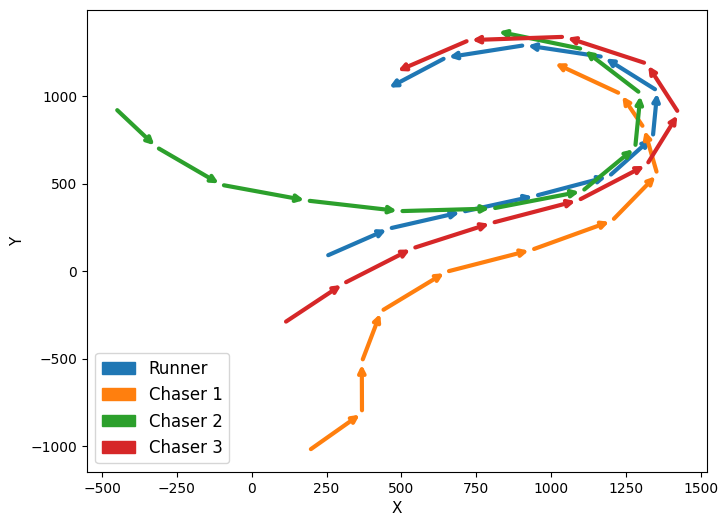

In [12]:
def arrow_plot(ax, df, color, lw, label):
    n = max(1, len(df) // 10)
    for i in range(0, len(df)-n, n):
        ax.annotate(
            '',
            xy=(df.x.iloc[i+n], df.y.iloc[i+n]),
            xytext=(df.x.iloc[i], df.y.iloc[i]),
            arrowprops=dict(arrowstyle="->", color=color, lw=lw, alpha=1, label=label)
        )
    legend_handles.append(mpatches.Patch(color=color, label=label))

legend_handles = []

scen_index = 26

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(agent0[scen_index].x, agent0[scen_index].y, alpha=0)
arrow_plot(ax, agent0[scen_index], color='C0', lw=3, label='Runner')

ax.plot(agent1[scen_index].x, agent1[scen_index].y, alpha=0)
arrow_plot(ax, agent1[scen_index], color='C1', lw=3, label='Chaser 1')

ax.plot(agent2[scen_index].x, agent2[scen_index].y, alpha=0)
arrow_plot(ax, agent2[scen_index], color='C2', lw=3, label='Chaser 2')

ax.plot(agent3[scen_index].x, agent3[scen_index].y, alpha=0)
arrow_plot(ax, agent3[scen_index], color='C3', lw=3, label='Chaser 3')


ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)

ax.legend(handles=legend_handles, fontsize=12)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# fig.savefig('./img/schola-data.pdf', dpi=300, format='pdf', bbox_inches='tight')


# animate_scenario(agent0[scen_index], agent1[scen_index], agent2[scen_index], agent3[scen_index])
# animate_scenario()

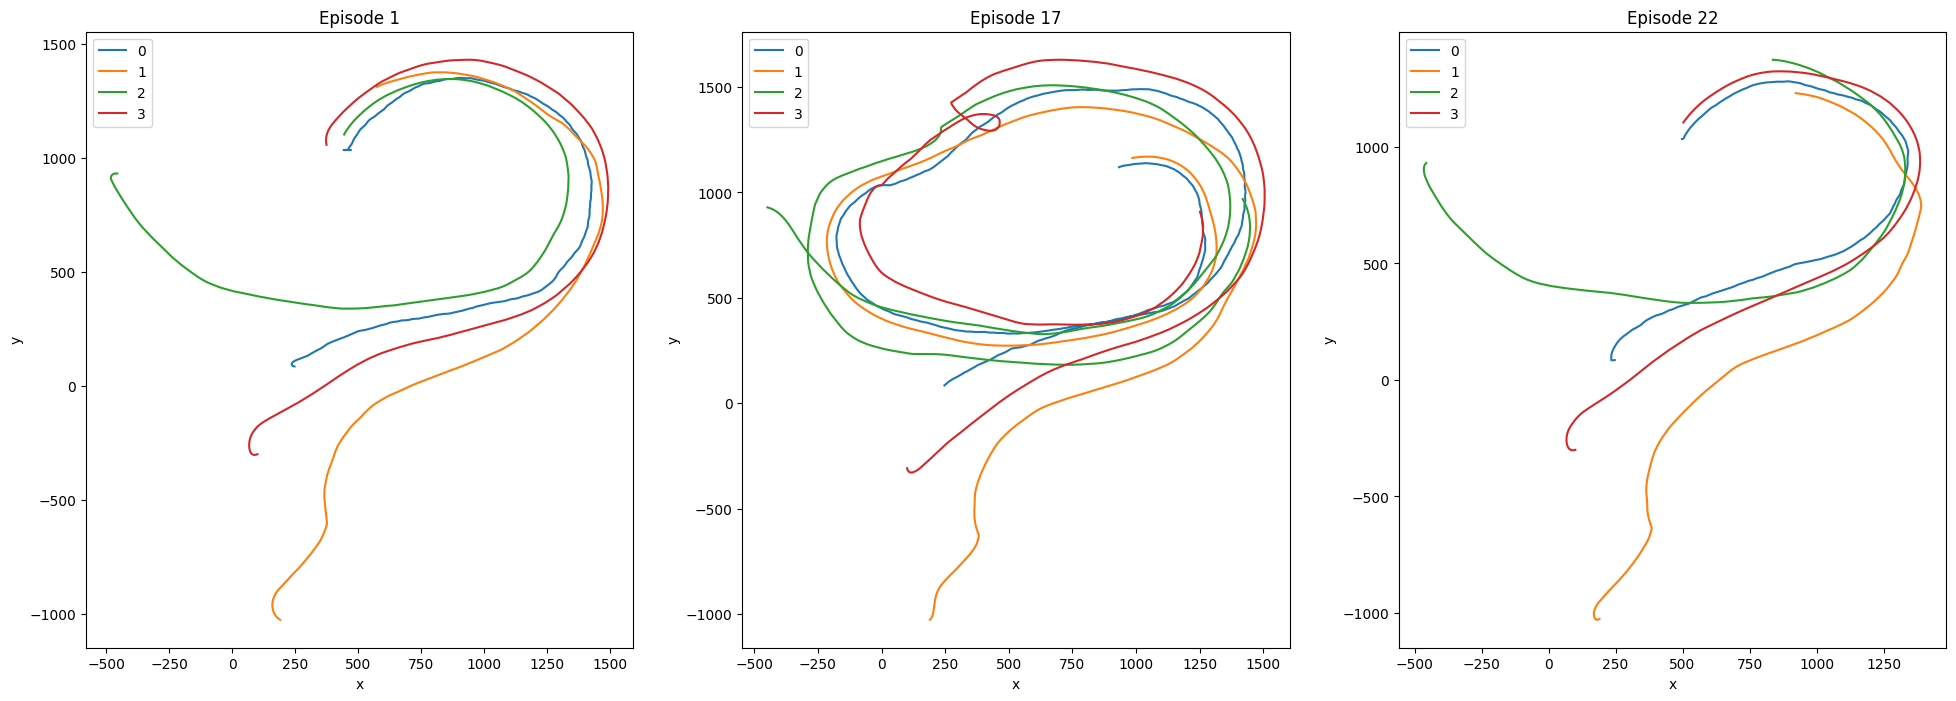

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(24,8))

for i, scen_index in enumerate([1, 17, 22]):
    ax[i].set_title(f'Episode {scen_index}')

    ax[i].plot(agent0[scen_index].x, agent0[scen_index].y, label='0')
    ax[i].plot(agent1[scen_index].x, agent1[scen_index].y, label='1')
    ax[i].plot(agent2[scen_index].x, agent2[scen_index].y, label='2')
    ax[i].plot(agent3[scen_index].x, agent3[scen_index].y, label='3')

    ax[i].set_ylabel('y')
    ax[i].set_xlabel('x')

    ax[i].legend()

plt.show()

# animate_scenario(agent0[scen_index], agent1[scen_index], agent2[scen_index], agent3[scen_index]);

## Episode 1

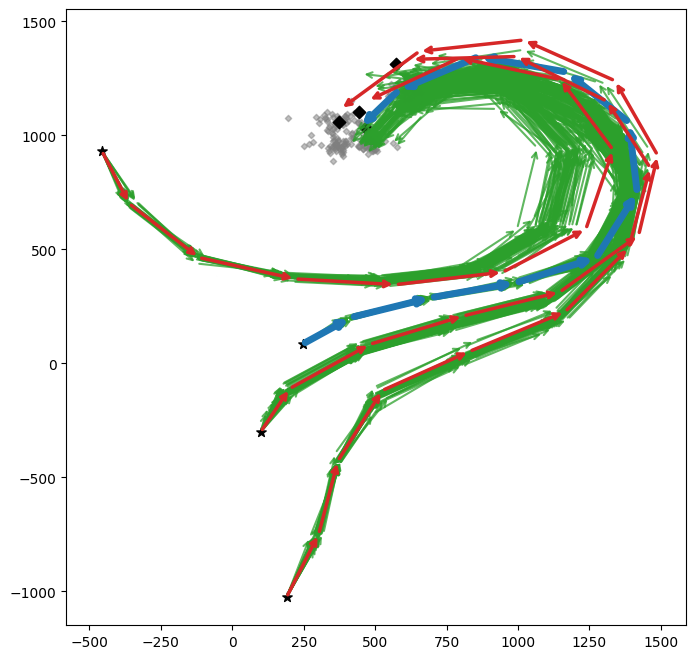

- Agent 0 -----------------------------
DTW-Var: 10217.05
               Mean	    Var	     CV
CT-5-7:     -4.22	   0.42	  -0.15
CT-10-7:     -4.13	   0.02	  -0.03
CT-15-7:     -2.70	   0.10	  -0.12
- Agent 1 -----------------------------
DTW-Var: 11920.24
               Mean	    Var	     CV
CT-5-8:     -0.91	   0.15	  -0.42
CT-10-8:     -0.78	   0.07	  -0.34
CT-15-8:     -0.63	   0.12	  -0.56
- Agent 2 -----------------------------
DTW-Var: 14072.15
               Mean	    Var	     CV
CT-5-9:     -2.87	   0.30	  -0.19
CT-10-9:     -2.03	   0.15	  -0.19
CT-15-9:     -1.45	   0.13	  -0.25
- Agent 3 -----------------------------
DTW-Var: 14431.60
               Mean	    Var	     CV
CT-5-9:     -2.74	   0.37	  -0.22
CT-10-9:     -2.55	   0.16	  -0.16
CT-15-9:     -1.27	   0.18	  -0.34


In [14]:
scenario_dir = './synthetic/output/set6/scen1-mf-ban2-chol2-10-offset/'
test_dir = './schola/sets/set6/'
train_episode = 1
test_episode = 17

Q = plot_scenario(scenario_dir, ax=plt.subplots(figsize=(8,8))[1], original=True)
plt.show()

T0 = pd.read_csv(os.path.join(scenario_dir, 'agent0/original.csv'))
T1 = pd.read_csv(os.path.join(scenario_dir, 'agent1/original.csv'))
T2 = pd.read_csv(os.path.join(scenario_dir, 'agent2/original.csv'))
T3 = pd.read_csv(os.path.join(scenario_dir, 'agent3/original.csv'))

Pn0 = pd.read_csv(os.path.join(test_dir, f'agent0/scen{test_episode}.csv'))
Pn1 = pd.read_csv(os.path.join(test_dir, f'agent1/scen{test_episode}.csv'))
Pn2 = pd.read_csv(os.path.join(test_dir, f'agent2/scen{test_episode}.csv'))
Pn3 = pd.read_csv(os.path.join(test_dir, f'agent3/scen{test_episode}.csv'))

T = [T0, T1, T2, T3]
Pn = [Pn0, Pn1, Pn2, Pn3]


for i in range(4):
    mask = np.loadtxt(os.path.join(test_dir, f'agent{i}/scen{train_episode}-mask.txt'), dtype=int)
    n_clusters = len(mask)
    print(f'- Agent {i} -----------------------------')
    print(f'DTW-Var: {dtw_variation(Q[i]):7.2f}')
    print(f'            {"Mean":>7}\t{"Var":>7}\t{"CV":>7}')
    print(f'CT-5-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=5, n_clusters=n_clusters))}')
    print(f'CT-10-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=10, n_clusters=n_clusters))}')
    print(f'CT-15-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=15, n_clusters=n_clusters))}')

# animate_scenario(gaussian_smoothing(Q[0][1]), gaussian_smoothing(Q[1][1]), gaussian_smoothing(Q[2][1]), gaussian_smoothing(Q[3][1]), T0, T1, T2, T3, savefile=os.path.join(scenario_dir, 'both.gif'));
# animate_scenario(T0, T1, T2, T3, savefile=os.path.join(scenario_dir, 'original.gif'));
# animate_scenario(gaussian_smoothing(Q[0][1]), gaussian_smoothing(Q[1][1]), gaussian_smoothing(Q[2][1]), gaussian_smoothing(Q[3][1]), savefile=os.path.join(scenario_dir, 'synthetic.gif'));

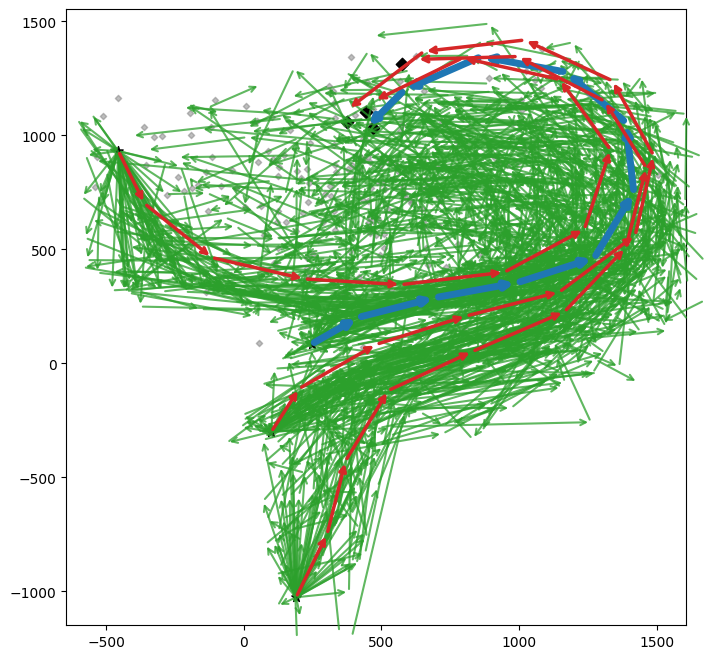

- Agent 0 -----------------------------
DTW-Var: 114199.49
               Mean	    Var	     CV
CT-5-7:      0.86	   1.37	   1.36
CT-10-7:      1.00	   0.79	   0.89
CT-15-7:      1.19	   0.34	   0.49
- Agent 1 -----------------------------
DTW-Var: 138126.36
               Mean	    Var	     CV
CT-5-8:      2.45	   0.70	   0.34
CT-10-8:      1.07	   0.24	   0.45
CT-15-8:      1.66	   0.15	   0.23
- Agent 2 -----------------------------
DTW-Var: 135436.58
               Mean	    Var	     CV
CT-5-9:      1.30	   0.68	   0.64
CT-10-9:      1.62	   0.59	   0.48
CT-15-9:      1.10	   0.26	   0.46
- Agent 3 -----------------------------
DTW-Var: 115409.21
               Mean	    Var	     CV
CT-5-9:      1.75	   1.89	   0.79
CT-10-9:      1.20	   0.66	   0.68
CT-15-9:      1.34	   0.60	   0.58


In [15]:
scenario_dir = './synthetic/output/set6/scen1-mf-ban10-chol2-50-offset/'
test_dir = './schola/sets/set6/'
train_episode = 1
test_episode = 17

Q = plot_scenario(scenario_dir, ax=plt.subplots(figsize=(8,8))[1], original=True)
plt.show()

T0 = pd.read_csv(os.path.join(scenario_dir, 'agent0/original.csv'))
T1 = pd.read_csv(os.path.join(scenario_dir, 'agent1/original.csv'))
T2 = pd.read_csv(os.path.join(scenario_dir, 'agent2/original.csv'))
T3 = pd.read_csv(os.path.join(scenario_dir, 'agent3/original.csv'))

Pn0 = pd.read_csv(os.path.join(test_dir, f'agent0/scen{test_episode}.csv'))
Pn1 = pd.read_csv(os.path.join(test_dir, f'agent1/scen{test_episode}.csv'))
Pn2 = pd.read_csv(os.path.join(test_dir, f'agent2/scen{test_episode}.csv'))
Pn3 = pd.read_csv(os.path.join(test_dir, f'agent3/scen{test_episode}.csv'))

T = [T0, T1, T2, T3]
Pn = [Pn0, Pn1, Pn2, Pn3]


for i in range(4):
    mask = np.loadtxt(os.path.join(test_dir, f'agent{i}/scen{train_episode}-mask.txt'), dtype=int)
    n_clusters = len(mask)
    print(f'- Agent {i} -----------------------------')
    print(f'DTW-Var: {dtw_variation(Q[i]):7.2f}')
    print(f'            {"Mean":>7}\t{"Var":>7}\t{"CV":>7}')
    print(f'CT-5-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=5, n_clusters=n_clusters))}')
    print(f'CT-10-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=10, n_clusters=n_clusters))}')
    print(f'CT-15-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=15, n_clusters=n_clusters))}')

# animate_scenario(gaussian_smoothing(Q[0][1]), gaussian_smoothing(Q[1][1]), gaussian_smoothing(Q[2][1]), gaussian_smoothing(Q[3][1]), T0, T1, T2, T3, savefile=os.path.join(scenario_dir, 'both.gif'));
# animate_scenario(T0, T1, T2, T3, savefile=os.path.join(scenario_dir, 'original.gif'));
# animate_scenario(gaussian_smoothing(Q[0][1]), gaussian_smoothing(Q[1][1]), gaussian_smoothing(Q[2][1]), gaussian_smoothing(Q[3][1]), savefile=os.path.join(scenario_dir, 'synthetic.gif'));

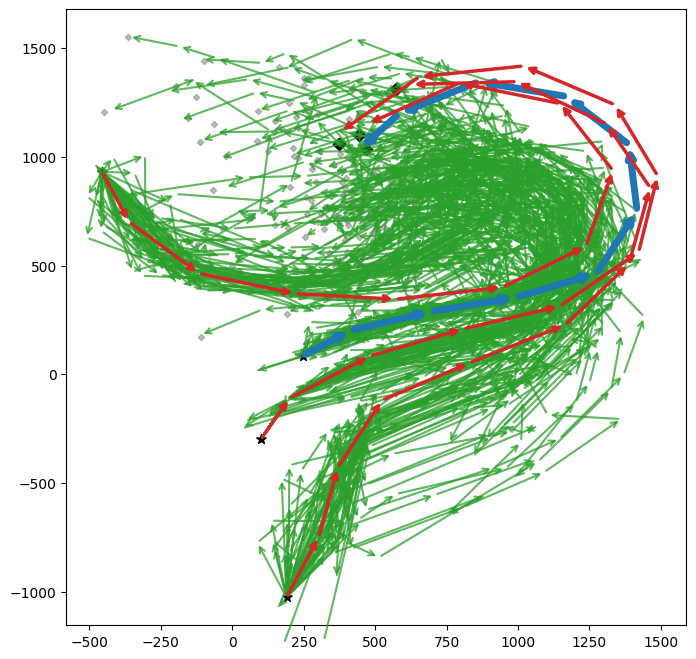

- Agent 0 -----------------------------
DTW-Var: 62874.58
               Mean	    Var	     CV
CT-5-7:      0.19	   0.55	   3.90
CT-10-7:      0.34	   0.26	   1.51
CT-15-7:      0.41	   0.14	   0.93
- Agent 1 -----------------------------
DTW-Var: 100349.14
               Mean	    Var	     CV
CT-5-8:      2.75	   0.92	   0.35
CT-10-8:      1.18	   0.23	   0.41
CT-15-8:      1.65	   0.31	   0.34
- Agent 2 -----------------------------
DTW-Var: 94908.94
               Mean	    Var	     CV
CT-5-9:      0.71	   0.84	   1.29
CT-10-9:      0.47	   0.72	   1.83
CT-15-9:      0.56	   0.27	   0.93
- Agent 3 -----------------------------
DTW-Var: 90452.03
               Mean	    Var	     CV
CT-5-9:      0.06	   1.11	  18.28
CT-10-9:      0.67	   0.34	   0.86
CT-15-9:      0.30	   0.33	   1.88


In [16]:
scenario_dir = './synthetic/output/set6/scen1-mf-ban20-chol2-10-offset/'
test_dir = './schola/sets/set6/'
train_episode = 1
test_episode = 17

Q = plot_scenario(scenario_dir, ax=plt.subplots(figsize=(8,8))[1], original=True)
plt.show()

T0 = pd.read_csv(os.path.join(scenario_dir, 'agent0/original.csv'))
T1 = pd.read_csv(os.path.join(scenario_dir, 'agent1/original.csv'))
T2 = pd.read_csv(os.path.join(scenario_dir, 'agent2/original.csv'))
T3 = pd.read_csv(os.path.join(scenario_dir, 'agent3/original.csv'))

Pn0 = pd.read_csv(os.path.join(test_dir, f'agent0/scen{test_episode}.csv'))
Pn1 = pd.read_csv(os.path.join(test_dir, f'agent1/scen{test_episode}.csv'))
Pn2 = pd.read_csv(os.path.join(test_dir, f'agent2/scen{test_episode}.csv'))
Pn3 = pd.read_csv(os.path.join(test_dir, f'agent3/scen{test_episode}.csv'))

T = [T0, T1, T2, T3]
Pn = [Pn0, Pn1, Pn2, Pn3]


for i in range(4):
    mask = np.loadtxt(os.path.join(test_dir, f'agent{i}/scen{train_episode}-mask.txt'), dtype=int)
    n_clusters = len(mask)
    print(f'- Agent {i} -----------------------------')
    print(f'DTW-Var: {dtw_variation(Q[i]):7.2f}')
    print(f'            {"Mean":>7}\t{"Var":>7}\t{"CV":>7}')
    print(f'CT-5-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=5, n_clusters=n_clusters))}')
    print(f'CT-10-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=10, n_clusters=n_clusters))}')
    print(f'CT-15-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=15, n_clusters=n_clusters))}')

# animate_scenario(gaussian_smoothing(Q[0][1]), gaussian_smoothing(Q[1][1]), gaussian_smoothing(Q[2][1]), gaussian_smoothing(Q[3][1]), T0, T1, T2, T3, savefile=os.path.join(scenario_dir, 'both.gif'));
# animate_scenario(T0, T1, T2, T3, savefile=os.path.join(scenario_dir, 'original.gif'));
# animate_scenario(gaussian_smoothing(Q[0][1]), gaussian_smoothing(Q[1][1]), gaussian_smoothing(Q[2][1]), gaussian_smoothing(Q[3][1]), savefile=os.path.join(scenario_dir, 'synthetic.gif'));

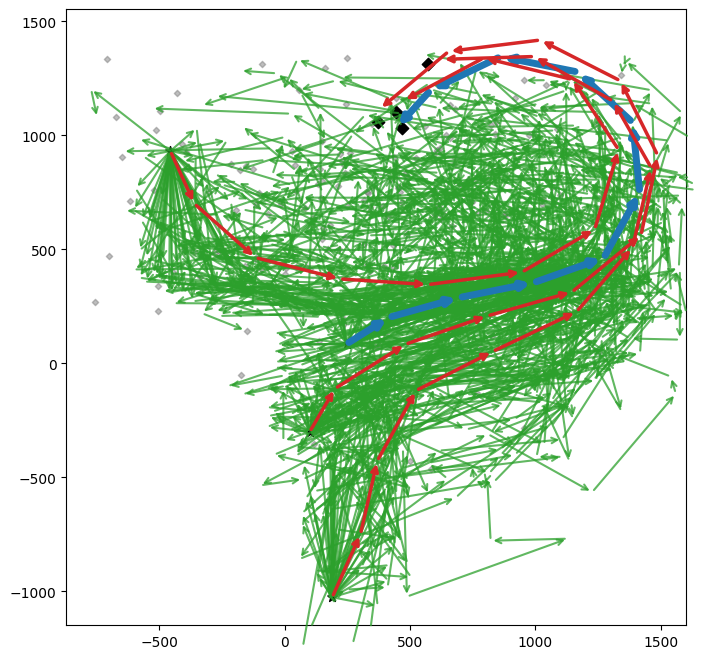

- Agent 0 -----------------------------
DTW-Var: 143491.48
               Mean	    Var	     CV
CT-5-7:      1.45	   1.33	   0.79
CT-10-7:      1.49	   0.50	   0.47
CT-15-7:      1.41	   0.36	   0.42
- Agent 1 -----------------------------
DTW-Var: 170251.76
               Mean	    Var	     CV
CT-5-8:      3.28	   1.31	   0.35
CT-10-8:      1.29	   0.46	   0.52
CT-15-8:      2.09	   0.46	   0.32
- Agent 2 -----------------------------
DTW-Var: 152469.00
               Mean	    Var	     CV
CT-5-9:      1.69	   0.77	   0.52
CT-10-9:      1.82	   0.46	   0.37
CT-15-9:      1.23	   0.30	   0.44
- Agent 3 -----------------------------
DTW-Var: 155540.78
               Mean	    Var	     CV
CT-5-9:      1.74	   2.37	   0.88
CT-10-9:      1.41	   0.68	   0.59
CT-15-9:      1.32	   0.68	   0.63


In [17]:
scenario_dir = './synthetic/output/set6/scen1-mf-ban10-chol2-100-offset/'
test_dir = './schola/sets/set6/'
train_episode = 1
test_episode = 17

Q = plot_scenario(scenario_dir, ax=plt.subplots(figsize=(8,8))[1], original=True)
plt.show()

T0 = pd.read_csv(os.path.join(scenario_dir, 'agent0/original.csv'))
T1 = pd.read_csv(os.path.join(scenario_dir, 'agent1/original.csv'))
T2 = pd.read_csv(os.path.join(scenario_dir, 'agent2/original.csv'))
T3 = pd.read_csv(os.path.join(scenario_dir, 'agent3/original.csv'))

Pn0 = pd.read_csv(os.path.join(test_dir, f'agent0/scen{test_episode}.csv'))
Pn1 = pd.read_csv(os.path.join(test_dir, f'agent1/scen{test_episode}.csv'))
Pn2 = pd.read_csv(os.path.join(test_dir, f'agent2/scen{test_episode}.csv'))
Pn3 = pd.read_csv(os.path.join(test_dir, f'agent3/scen{test_episode}.csv'))

T = [T0, T1, T2, T3]
Pn = [Pn0, Pn1, Pn2, Pn3]


for i in range(4):
    mask = np.loadtxt(os.path.join(test_dir, f'agent{i}/scen{train_episode}-mask.txt'), dtype=int)
    n_clusters = len(mask)
    print(f'- Agent {i} -----------------------------')
    print(f'DTW-Var: {dtw_variation(Q[i]):7.2f}')
    print(f'            {"Mean":>7}\t{"Var":>7}\t{"CV":>7}')
    print(f'CT-5-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=5, n_clusters=n_clusters))}')
    print(f'CT-10-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=10, n_clusters=n_clusters))}')
    print(f'CT-15-{n_clusters}:   {pprint(C_T_agg(Pn[i], Q[i], T[i], tau=0, dim=15, n_clusters=n_clusters))}')

# animate_scenario(gaussian_smoothing(Q[0][1]), gaussian_smoothing(Q[1][1]), gaussian_smoothing(Q[2][1]), gaussian_smoothing(Q[3][1]), T0, T1, T2, T3, savefile=os.path.join(scenario_dir, 'both.gif'));
# animate_scenario(T0, T1, T2, T3, savefile=os.path.join(scenario_dir, 'original.gif'));
# animate_scenario(gaussian_smoothing(Q[0][1]), gaussian_smoothing(Q[1][1]), gaussian_smoothing(Q[2][1]), gaussian_smoothing(Q[3][1]), savefile=os.path.join(scenario_dir, 'synthetic.gif'));

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


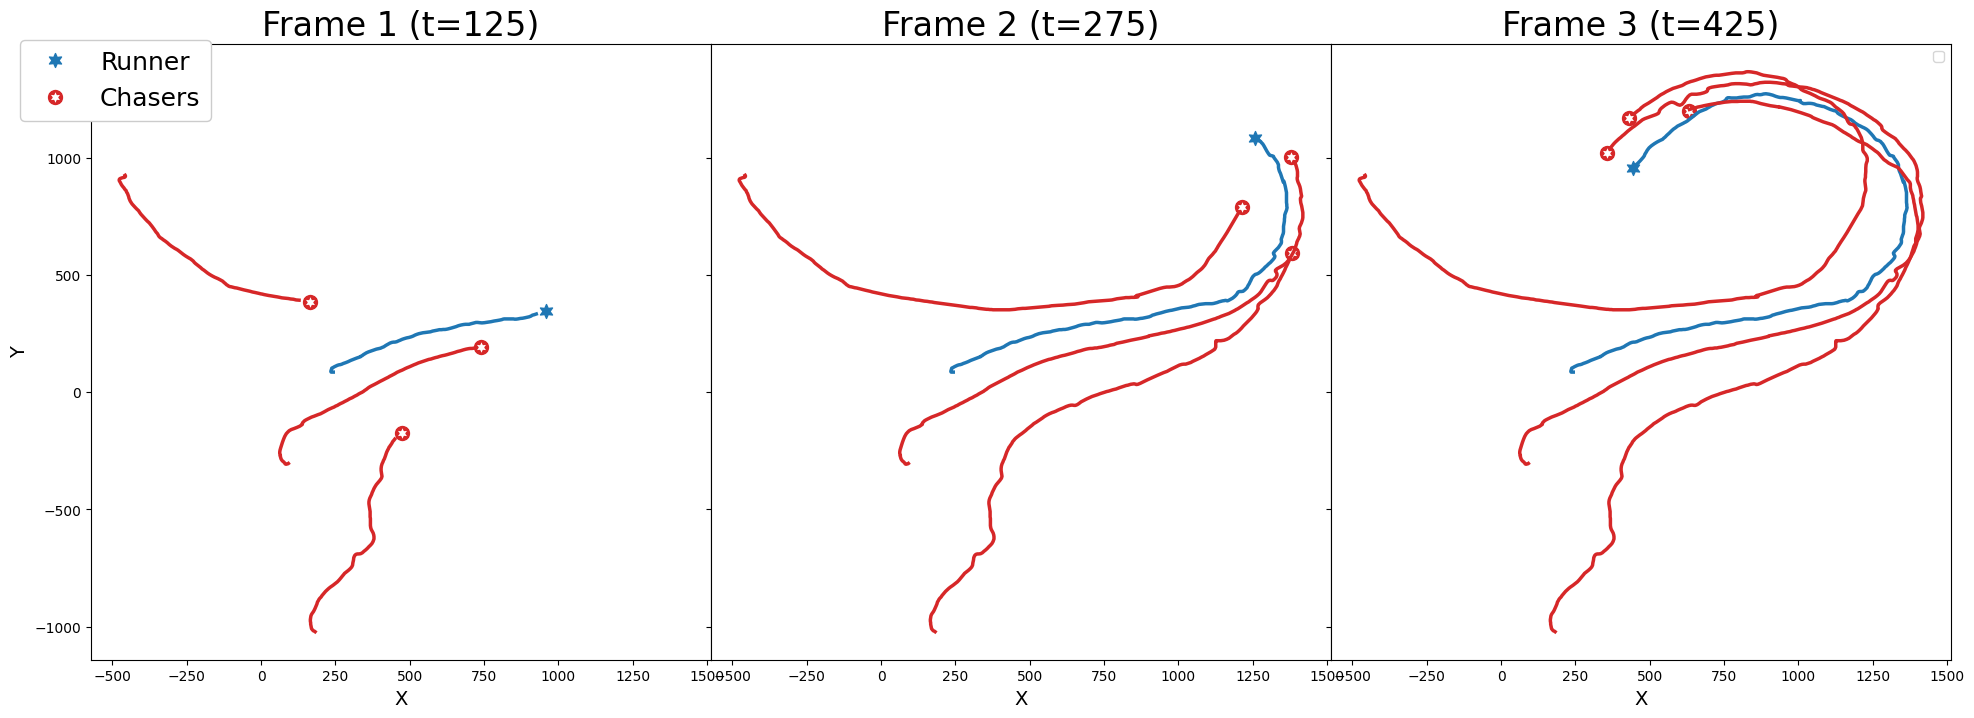

In [18]:
scenario_csv = './synthetic/output/set6/scen1-mf-ban2-chol2-10-offset/'

path0 = gaussian_smoothing(load_synthetic(os.path.join(scenario_csv, 'agent0'))[1])
path1 = gaussian_smoothing(load_synthetic(os.path.join(scenario_csv, 'agent1'))[1])
path2 = gaussian_smoothing(load_synthetic(os.path.join(scenario_csv, 'agent2'))[1])
path3 = gaussian_smoothing(load_synthetic(os.path.join(scenario_csv, 'agent3'))[1])

fig, ax = plt.subplots(ncols=3, figsize=(24,8))
plt.subplots_adjust(hspace=0, wspace=0)
plt.legend()

ax[0].set_ylabel('Y', fontsize=14)
ax[0].set_xlabel('X', fontsize=14)
ax[1].set_xlabel('X', fontsize=14)
ax[2].set_xlabel('X', fontsize=14)
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

ax[0].set_title('Frame 1 (t=125)', fontsize=24)
ax[1].set_title('Frame 2 (t=275)', fontsize=24)
ax[2].set_title('Frame 3 (t=425)', fontsize=24)

frame = 125

line0, = ax[0].plot(path0.x[:frame-3], path0.y[:frame-3], c='C0', lw=2.5)
line1, = ax[0].plot(path1.x[:frame-3], path1.y[:frame-3], c='C3', lw=2.5)
line2, = ax[0].plot(path2.x[:frame-3], path2.y[:frame-3], c='C3', lw=2.5)
line3, = ax[0].plot(path3.x[:frame-3], path3.y[:frame-3], c='C3', lw=2.5)

mark0 = ax[0].scatter(path0.x[frame], path0.y[frame], marker=star, color='C0', label='Runner', s=100)
mark1 = ax[0].scatter(path1.x[frame], path1.y[frame], marker=cut_star, color='C3', label='Chaser 1', s=100)
mark2 = ax[0].scatter(path2.x[frame], path2.y[frame], marker=cut_star, color='C3', label='Chaser 2', s=100)
mark3 = ax[0].scatter(path3.x[frame], path3.y[frame], marker=cut_star, color='C3', label='Chaser 3', s=100)

frame = 275

line0, = ax[1].plot(path0.x[:frame-3], path0.y[:frame-3], c='C0', lw=2.5)
line1, = ax[1].plot(path1.x[:frame-3], path1.y[:frame-3], c='C3', lw=2.5)
line2, = ax[1].plot(path2.x[:frame-3], path2.y[:frame-3], c='C3', lw=2.5)
line3, = ax[1].plot(path3.x[:frame-3], path3.y[:frame-3], c='C3', lw=2.5)

mark0 = ax[1].scatter(path0.x[frame], path0.y[frame], marker=star, color='C0', label='Runner', s=100)
mark1 = ax[1].scatter(path1.x[frame], path1.y[frame], marker=cut_star, color='C3', label='Chaser 1', s=100)
mark2 = ax[1].scatter(path2.x[frame], path2.y[frame], marker=cut_star, color='C3', label='Chaser 2', s=100)
mark3 = ax[1].scatter(path3.x[frame], path3.y[frame], marker=cut_star, color='C3', label='Chaser 3', s=100)

frame = 425

line0, = ax[2].plot(path0.x[:frame-3], path0.y[:frame-3], c='C0', lw=2.5)
line1, = ax[2].plot(path1.x[:frame-3], path1.y[:frame-3], c='C3', lw=2.5)
line2, = ax[2].plot(path2.x[:frame-3], path2.y[:frame-3], c='C3', lw=2.5)
line3, = ax[2].plot(path3.x[:frame-3], path3.y[:frame-3], c='C3', lw=2.5)

mark0 = ax[2].scatter(path0.x[frame], path0.y[frame], marker=star, color='C0', label='Runner', s=100)
mark1 = ax[2].scatter(path1.x[frame], path1.y[frame], marker=cut_star, color='C3', label='Chaser 1', s=100)
mark2 = ax[2].scatter(path2.x[frame], path2.y[frame], marker=cut_star, color='C3', label='Chaser 2', s=100)
mark3 = ax[2].scatter(path3.x[frame], path3.y[frame], marker=cut_star, color='C3', label='Chaser 3', s=100)


ax[0].set_xlim(ax[2].get_xlim())
ax[0].set_ylim(ax[2].get_ylim())
ax[1].set_xlim(ax[2].get_xlim())
ax[1].set_ylim(ax[2].get_ylim())


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=star, color='C0', linestyle='', markersize=10, label='Runner'),
    Line2D([0], [0], marker=cut_star, color='C3', linestyle='', markersize=10, label='Chasers')
]

fig.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(0.18, 0.9), framealpha=1, fontsize=18)

# fig.savefig('./img/schola-frames.pdf', dpi=300, format='pdf', bbox_inches='tight')

plt.show()

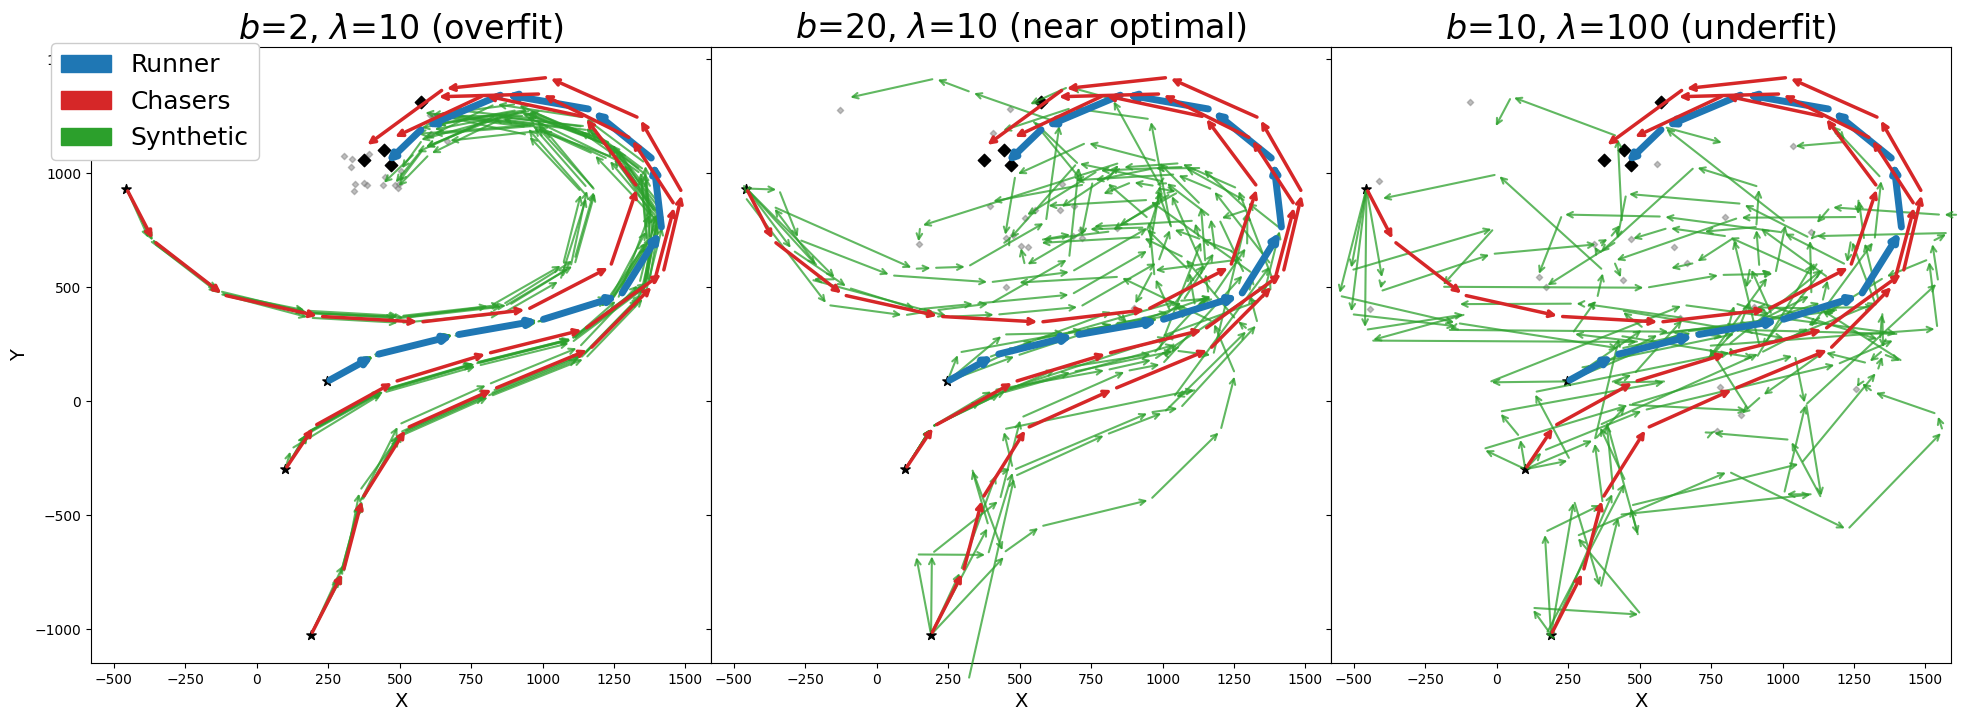

In [19]:
scenario_1 = './synthetic/output/set6/scen1-mf-ban2-chol2-10-offset/'
scenario_2 = './synthetic/output/set6/scen1-mf-ban20-chol2-10-offset/'
scenario_3 = './synthetic/output/set6/scen1-mf-ban10-chol2-100-offset/'

ax = plt.subplots(ncols=3, figsize=(24,8), sharey=True)[1]
plt.subplots_adjust(wspace=0, hspace=0)

plot_scenario(scenario_1, ax=ax[0], original=True, max_paths=5)
plot_scenario(scenario_2, ax=ax[1], original=True, max_paths=5)
plot_scenario(scenario_3, ax=ax[2], original=True, max_paths=5)

ax[0].set_title('$b$=2, $\lambda$=10 (overfit)', fontsize=24)
ax[1].set_title('$b$=20, $\lambda$=10 (near optimal)', fontsize=24)
ax[2].set_title('$b$=10, $\lambda$=100 (underfit)', fontsize=24)
ax[0].set_ylabel('Y', fontsize=14)
ax[0].set_xlabel('X', fontsize=14)
ax[1].set_xlabel('X', fontsize=14)
ax[2].set_xlabel('X', fontsize=14)

patch1 = mpatches.Patch(color='C0', label='Runner')
patch2 = mpatches.Patch(color='C3', label='Chasers')
patch3 = mpatches.Patch(color='C2', label='Synthetic')

fig = plt.gcf()
fig.legend(handles=[patch1, patch2, patch3], ncol=1, bbox_to_anchor=(0.2, 0.9), framealpha=1, fontsize=18)

# fig.savefig('./img/schola-experiments.pdf', dpi=300, format='pdf', bbox_inches='tight')

plt.show()